In [1]:
import sys
# See which Python it's running
sys.executable

'/usr/local/opt/python/bin/python3.7'

In [2]:
# See where it's looking for imports
sys.path

['/Users/kibanez/git/STR_detection_python3',
 '/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python37.zip',
 '/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7',
 '/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/lib-dynload',
 '',
 '/Users/kibanez/Library/Python/3.7/lib/python/site-packages',
 '/usr/local/lib/python3.7/site-packages',
 '/usr/local/lib/python3.7/site-packages/IPython/extensions',
 '/Users/kibanez/.ipython']

In [3]:
import itertools
import numpy as np
import scipy
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
%matplotlib inline

In [4]:
import json
import os

In [5]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 16

Load data

In [6]:
# This file has been generated from the golden table, taking EHv255 estimations for GEL and EHv312 for ICSL
# Repeats > 200 -- recoded to 201
repeat_sizes = pd.read_csv('/Users/kibanez/Documents/STRs/VALIDATION/table_validation_GEL_EHv255_ICSL_EHv312_for_swim_lane.tsv', sep='\t')
repeat_sizes.head()
#np.unique(repeat_sizes['locus_bioinfo'])
#np.unique(repeat_sizes['new_classification_avg'])
# array(['FN', 'FP', 'TN', 'TP'], dtype=object)

,locus_bioinfo,validation_cohort,LP_number,gender,EH_a1_avg,EH_a2_avg,classification_a1_avg,classification_a2_avg,threshold.normal,threshold.pathogenic
0,AR,GEL,LP2000254-DNA_C12,male,23,NaN,TN,NaN,34,37
1,AR,GEL,LP2000254-DNA_D06,female,26,27.0,TN,TN,34,37
2,AR,GEL,LP2000261-DNA_B10,male,15,NaN,TN,NaN,34,37
3,AR,GEL,LP2000266-DNA_G03,male,20,NaN,TN,NaN,34,37
4,AR,GEL,LP2000266-DNA_G04,male,27,NaN,TN,NaN,34,37


Prepare data for plotting

In [7]:
repeat_info = {
    'AR':      {'expected_range': [34, 37],   'unit_len': 3, 'index': 12},
    'ATN1':    {'expected_range': [34, 47],   'unit_len': 3, 'index': 11},
    'ATXN1':   {'expected_range': [35, 43],   'unit_len': 3, 'index': 10},
    'ATXN2':   {'expected_range': [31, 32],   'unit_len': 3, 'index': 9},    
    'ATXN3':   {'expected_range': [43, 59],   'unit_len': 3, 'index': 8},    
    'ATXN7':   {'expected_range': [17, 35],   'unit_len': 3, 'index': 7},    
    'CACNA1A':   {'expected_range': [17, 19],   'unit_len': 3, 'index': 6},    
    'C9orf72':   {'expected_range': [30, 59],   'unit_len': 6, 'index': 5},
    'DMPK':   {'expected_range': [49, 50],   'unit_len': 3, 'index': 4},
    'FMR1':    {'expected_range': [49, 199],  'unit_len': 3, 'index': 3},
    'FXN':     {'expected_range': [44, 65],   'unit_len': 3, 'index': 2},
    'HTT':     {'expected_range': [35, 39],   'unit_len': 3, 'index': 1},
#    'PPP2R2B':    {'expected_range': [32, 51],   'unit_len': 3, 'index': 1},
    'TBP':    {'expected_range': [41, 48],   'unit_len': 3, 'index': 0}
}

In [8]:
# Function to map the colors as a list 
def pltcolor(lst):
    cols=[]
    for l in lst:
        if l=='TP':
            cols.append('red')
        elif l=='TN':
            cols.append('blue')
        elif l=='FP':
            cols.append('blue')
        else:
            cols.append('red')
    return cols


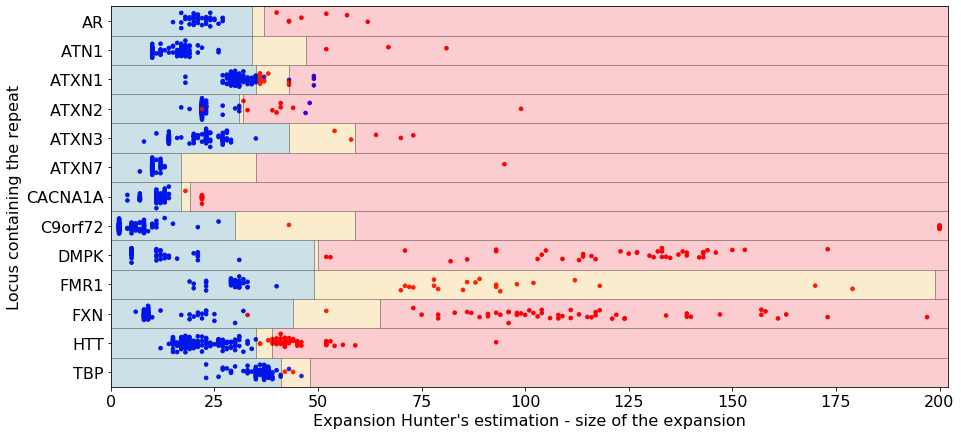

In [9]:
max_repeat_size = 202

fig, ax = plt.subplots(figsize=(15, 7))

for repeat_id, rec in repeat_sizes.groupby(by='locus_bioinfo'):
    normal_cutoff, premutation_cutoff = repeat_info[repeat_id]['expected_range']
    base_y = repeat_info[repeat_id]['index']
    
    ax.add_patch(patches.Rectangle((0, base_y - 0.5),
                                   normal_cutoff, 1.0,
                                   facecolor='#046b87', alpha=0.2, ec='k'))
    
    ax.add_patch(patches.Rectangle((normal_cutoff, base_y - 0.5),
                                   premutation_cutoff - normal_cutoff,
                                   1.0, facecolor='#eda407', alpha=0.2, ec='k'))

    ax.add_patch(patches.Rectangle((premutation_cutoff, base_y - 0.5),
                                   max_repeat_size - premutation_cutoff,
                                   1.0, facecolor='#ed0716', alpha=0.2, ec='k'))

    
    #allele_sizes = list(rec.max_EH_allele)

    # Doing with repeat-sizes
    allele_sizes = list(rec.EH_a1_avg) +  list(rec.EH_a2_avg)
    
    # Doing with repeat-sizes
    ys = np.random.normal(base_y, 0.12, len(allele_sizes))
    
    classi = list(rec.classification_a1_avg) + list(rec.classification_a2_avg)
    
    # Create the colors list using the function above
    cols=pltcolor(classi)

    # Distinguish each dot color depending on whether they are TP (red), TN (blue), FP (blue), FN (red)
    #ax.scatter(allele_sizes, ys, c='black')
    
    # Doing with repeat-sizes
    ax.scatter(allele_sizes, ys, c=cols, s=13)
        
    gene_names = [(gene, rec['index']) for gene, rec in repeat_info.items()]
    gene_names = sorted(gene_names, key=lambda k: k[1])
    gene_names = [g for g, _ in gene_names]
    ax.yaxis.set_ticks(range(0, len(gene_names)))
    ax.yaxis.set_ticklabels(gene_names)
    ax.margins(x=0, y=0)
    ax.set(xlabel='Expansion Hunter\'s estimation - size of the expansion', ylabel='Locus containing the repeat');

In [10]:
# Let's save the plot into a PDF file
fig.savefig("/Users/kibanez/Documents/STRs/PAPERS/VALIDATION_PAPER/Figures/Figure1_EHv255_GEL_EHv312_ILMN_repeat-sizes-avg_RepeatUnit.pdf", bbox_inches='tight')

In [11]:
# Let's save the plot into a high quality PNG file - 600dpi
fig.savefig("/Users/kibanez/Documents/STRs/PAPERS/VALIDATION_PAPER/Figures/Figure1_EHv255_GEL_EHv312_ILMN_repeat-sizes-avg_RepeatUnit_600dpi.png", bbox_inches='tight', dpi=600)

In [12]:
# Let's save the plot into a high quality PNG file - 300dpi
fig.savefig("/Users/kibanez/Documents/STRs/PAPERS/VALIDATION_PAPER/Figures/Figure1_EHv255_GEL_EHv312_ILMN_repeat-sizes-avg_RepeatUnit_300dpi.png", bbox_inches='tight', dpi=300)